# Multi-group Agreement (German)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the Communities
and Crime dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_adult_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# German Dataset
Credit application records, where the goal is to predict whether an individual has
low or high credit risk. Sensitive attributes are age and gender. There are two versions of the German
Credit dataset, a “numeric” version which contains binarized versions of most categorical features (with
some removed), and a non-numeric version, which also contains categorical features. We do not use
the “numeric” version of the dataset used by several other works. We found the numeric version of
the dataset to be poorly-documented, lack useful features which were present in the “non-numeric”
version, and contain features which actually mixed multiple variables . Using the non-numeric version,
we extract separate features for sex and marital status (which are combined under a single feature in
the numeric dataset).

German Credit has $n = 1,000$ instances total, with $d = 22$ features.

In [4]:
root = "./datasets/german"
fp = os.path.join(root, "german.data")
df = pd.read_csv(
    fp, sep=" ", header=None)
df.columns = ["status", "duration", "credit_history",
              "purpose", "credit_amt", "savings_acct_bonds",
              "present_unemployed_since", "installment_rate",
              "per_status_sex", "other_debtors", "pres_res_since",
              "property", "age", "other_installment", "housing",
              "num_exist_credits", "job", "num_ppl", "has_phone",
              "foreign_worker", "target"]

# Code labels as in tfds; see
# https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/structured/german_credit_numeric.py
df["target"] = 2 - df["target"]

# convert per_status_sex into separate columns.
# Sens is 1 if male; else 0.
df["sex"] = df["per_status_sex"].apply(
    lambda x: 1 if x not in ["A92", "A95"] else 0)

# Age sens is 1 if above median age, else 0.
median_age = df["age"].median()
df["age"] = df["age"].apply(lambda x: 1 if x > median_age else 0)
df["single"] = df["per_status_sex"].apply(
    lambda x: 1 if x in ["A93", "A95"] else 0)
df.drop(columns="per_status_sex", inplace=True)

# features 15-23 are categorical/indicators
categorical_columns = [
    "status", "credit_history",
    "purpose", "savings_acct_bonds",
    "present_unemployed_since", "single",
    "other_debtors",
    "property", "other_installment", "housing",
    "job", "has_phone",
    "foreign_worker"]

for colname in categorical_columns:
    df[colname] = df[colname].astype('category')

df.head(5)

,status,duration,credit_history,purpose,credit_amt,savings_acct_bonds,present_unemployed_since,installment_rate,other_debtors,pres_res_since,...,other_installment,housing,num_exist_credits,job,num_ppl,has_phone,foreign_worker,target,sex,single
0,A11,6,A34,A43,1169,A65,A75,4,A101,4,...,A143,A152,2,A173,1,A192,A201,1,1,1
1,A12,48,A32,A43,5951,A61,A73,2,A101,2,...,A143,A152,1,A173,1,A191,A201,0,0,0
2,A14,12,A34,A46,2096,A61,A74,2,A101,3,...,A143,A152,1,A172,2,A191,A201,1,1,1
3,A11,42,A32,A42,7882,A61,A74,2,A103,4,...,A143,A153,1,A173,2,A191,A201,1,1,1
4,A11,24,A33,A40,4870,A61,A73,3,A101,4,...,A143,A153,2,A173,2,A191,A201,0,1,1


In [5]:
X, y = df.drop("target", axis=1), df["target"]
cat_idx = X.select_dtypes(include=["object", "bool", "category"]).columns
num_idx = X.select_dtypes(include=['int64', 'float64']).columns
steps = [('cat', OneHotEncoder(handle_unknown='ignore'), cat_idx), ('num', MinMaxScaler(), num_idx)]
col_transf = ColumnTransformer(steps)

# label encoder to target variale so we have two classes 0 and 1
assert(len(np.unique(y)) == 2)
y = LabelEncoder().fit_transform(y)
print("% examples (y=1): {}".format(100 * len(np.where(y == 1)[0])/len(y)))
print("% examples (y=0): {}".format(100 * len(np.where(y == 0)[0])/len(y)))

print("German Credit Shape: {}".format(df.shape))

% examples (y=1): 70.0
% examples (y=0): 30.0
German Credit Shape: (1000, 22)


In [15]:
def german_gp_indices(df, sex_val, age_val):
    if sex_val == "Male":
        return np.where((df['sex'] == 1) & (df['age'] == age_val))
    else:
        return np.where((df['sex'] == 0) & (df['age'] == age_val))

group_names = ["ALL", "M,O", "M,Y", "F,O", "F,Y", "M", "F", "O", "Y"]
group_memberships = []
group_memberships.append([True] * y.shape[0])
sex_gps = ["Male", "Female"]
age_gps = [1, 0]

# Traditional disjoint groups
for sex in sex_gps:
    for age in age_gps:
        indices = german_gp_indices(X, sex, age)[0]
        membership = np.zeros(y.shape[0], dtype=bool)
        membership[indices] = True
        group_memberships.append(membership)

# Add 4 overlapping groups
m_indices = np.where(X['sex'] == 1)
m_membership = np.zeros(y.shape[0], dtype=bool)
m_membership[m_indices] = True
group_memberships.append(m_membership)

f_indices = np.where(X['sex'] == 0)
f_membership = np.zeros(y.shape[0], dtype=bool)
f_membership[f_indices] = True
group_memberships.append(f_membership)

o_indices = np.where(X['age'] == 1)
o_membership = np.zeros(y.shape[0], dtype=bool)
o_membership[o_indices] = True
group_memberships.append(o_membership)

y_indices = np.where(X['age'] == 0)
y_membership = np.zeros(y.shape[0], dtype=bool)
y_membership[y_indices] = True
group_memberships.append(y_membership)

num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 9


In [16]:
# Fit the ColumnTransformer to X
X_transf = col_transf.fit_transform(X)
print("Column-transformed X has shape: {}".format(X_transf.shape))

# Train-test split
splits = train_test_split(*tuple([X, y] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

Column-transformed X has shape: (1000, 60)


In [17]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

# TODO: fix column alignment issue :(
print('Group\t\t\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t\t\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group			train	test
0 (ALL)			800	200
1 (M,O)			312	67
2 (M,Y)			250	61
3 (F,O)			88	17
4 (F,Y)			150	55
5 (M)			562	128
6 (F)			238	72
7 (O)			400	84
8 (Y)			400	116


In [18]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.71
P(Y=1 | group 1) = 0.7910447761194029
P(Y=1 | group 2) = 0.6885245901639344
P(Y=1 | group 3) = 0.8235294117647058
P(Y=1 | group 4) = 0.6
P(Y=1 | group 5) = 0.7421875
P(Y=1 | group 6) = 0.6527777777777778
P(Y=1 | group 7) = 0.7976190476190477
P(Y=1 | group 8) = 0.646551724137931


## Utilities for Training/Evaluation

In [19]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names):
    # Get test errors for each group
    test_err = {}
    std_errs = {}
    print("Group-conditional ERM Test Errors")
    for g in range(num_groups):
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        std_errs[g] = std_err(test_err[g], num_group_test[g])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, test_err[g], std_errs[g], num_group_test[g], group_names[g]))

    print()

    erm_test_err = {}
    erm_std_errs = {}
    print("Overall ERM Test Errors")
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
        erm_std_errs[g] = std_err(erm_test_err[g], num_group_test[g])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, erm_test_err[g], erm_std_errs[g], num_group_test[g], group_names[g]))

    return test_err, std_errs, erm_test_err, erm_std_errs
    
def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [20]:
XTICKS = ('G1 (M,O)', 'G2 (M,Y)', 'G3 (F,O)', 'G4 (F,Y)')
def plot_german_agreements(ax, group_pairs_agreements, group_pairs, group_names, model_class, bar_width=0.2, bar_groups=4, xticks=XTICKS, legend=True):
       # Plot "agreement" for each pair of intersecting groups
       index = np.arange(bar_groups)
       num_group_pairs = len(group_pairs_agreements)

       for i in range(0, num_group_pairs, 3):
              ax.bar(i/(bar_groups - 1) - bar_width, group_pairs_agreements[i], bar_width,
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i][0], group_names[group_pairs[i][0]],
                                                        group_pairs[i][1], group_names[group_pairs[i][1]]))
              ax.bar(i/(bar_groups - 1), group_pairs_agreements[i+1], bar_width,
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i+1][0], group_names[group_pairs[i+1][0]],
                                                        group_pairs[i+1][1], group_names[group_pairs[i+1][1]]))
              ax.bar(i/(bar_groups - 1) + bar_width, group_pairs_agreements[i+2], bar_width,
                     label="G{} ({}) $\cap$ G{} ({})".format(group_pairs[i+2][0], group_names[group_pairs[i+2][0]],
                                                        group_pairs[i+2][1], group_names[group_pairs[i+2][1]]))

       ax.set_xlabel('Intersecting Group')
       ax.set_ylabel('Agreement')
       ax.set_title('Group Agreements ({})'.format(model_class))
       ax.set_xticks(index, xticks)
       if legend:
              ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                     fancybox=True, shadow=True, ncol=3)

def plot_german_errors(ax, test_err, std_errs, erm_test_err, erm_std_errs, model_class, num_groups=num_groups, bar_width=0.2):
       # Error rate plots
       index = np.arange(num_groups)

       for g in range(num_groups):
              if g == 0:
                     ax.bar(g - 0.5 * bar_width, test_err[g], bar_width, yerr=std_errs[g], capsize=3, label="Group-ERM", color="blue")
                     ax.bar(g + 0.5 * bar_width, erm_test_err[g], bar_width, yerr=erm_std_errs[g], capsize=3, label="ERM", color="orange")
              else:
                     ax.bar(g - 0.5 * bar_width, test_err[g], bar_width, yerr=std_errs[g], capsize=3, color="blue")
                     ax.bar(g + 0.5 * bar_width, erm_test_err[g], bar_width, yerr=erm_std_errs[g], capsize=3, color="orange")
              ax.set_ylabel('Group-conditional Error Rate')
              ax.set_title('Group-conditional Error Rates of ERM (ALL) vs. Group-ERM ({})'.format(model_class))

       xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
       ax.set_xticks(index, xticks)
       ax.set_ylim([0, 0.5])
       ax.legend()

In [21]:
# Construct pairs of groups for "agreement" comparison
erm_group_pairs = list()
group_pairs = list()
group_pairs_cond = list()

# append G0 (ALL) paired with all other groups
for i in range(1, num_groups):
    erm_group_pairs.append((0, i))

# append pairs intersecting at G1 (M,O)
group_pairs.append((1,5))
group_pairs_cond.append(1)
group_pairs.append((5,7))
group_pairs_cond.append(1)
group_pairs.append((1,7))
group_pairs_cond.append(1)

# append pairs intersecting at G2 (M,Y)
group_pairs.append((2,5))
group_pairs_cond.append(2)
group_pairs.append((5,8))
group_pairs_cond.append(2)
group_pairs.append((2,8))
group_pairs_cond.append(2)

# append pairs intersecting at G3 (F,O)
group_pairs.append((3,6))
group_pairs_cond.append(3)
group_pairs.append((6,7))
group_pairs_cond.append(3)
group_pairs.append((3,7))
group_pairs_cond.append(3)

# append pairs intersecting at G4 (F,Y)
group_pairs.append((4,6))
group_pairs_cond.append(4)
group_pairs.append((6,8))
group_pairs_cond.append(4)
group_pairs.append((4,8))
group_pairs_cond.append(4)

# Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [23]:
# Train LogisticRegression models, one per group
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
model_path = os.path.join(SAVE_DATA_PATH, 'logreg_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'logreg_yhats.pkl')
prepend_path = os.path.join(SAVE_DATA_PATH, 'logreg_declist.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        logreg_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
    with open(prepend_path, 'rb') as f:
        dec_list = pickle.load(f)
else:
    params = {'max_iter': 250}
    logreg_models, yhats, test_err, erm_test_err, dec_list, F_test_err = train_and_eval(X_train, group_train, X_test, group_test, 
                                                                                        y_train, y_test, col_transf, num_groups, 
                                                                                        LogisticRegressionCV, params=params, verbose=True)

    with open(model_path, 'wb') as handle:
        pickle.dump(logreg_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(prepend_path, 'wb') as handle:
        pickle.dump(dec_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

lr_test_err, lr_std_err, lr_erm_test_err, lr_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.25 (+/-0.04330127018922193; n=200)
group 1 (M,O): 0.26865671641791045 (+/-0.0765838307905197; n=67)
group 2 (M,Y): 0.32786885245901637 (+/-0.08500161387980397; n=61)
group 3 (F,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.38181818181818183 (+/-0.09264459123715547; n=55)
group 5 (M): 0.2421875 (+/-0.053550897933028106; n=128)
group 6 (F): 0.3333333333333333 (+/-0.07856742013183862; n=72)
group 7 (O): 0.19047619047619047 (+/-0.06059133431241445; n=84)
group 8 (Y): 0.29310344827586204 (+/-0.05976878104551381; n=116)
PREPEND group 0 (ALL): 0.31 (+/-0.04624932431938871; n=200)
PREPEND group 1 (M,O): 0.26865671641791045 (+/-0.0765838307905197; n=67)
PREPEND group 2 (M,Y): 0.32786885245901637 (+/-0.08500161387980397; n=61)
PREPEND group 3 (F,O): 0.11764705882352941 (+/-0.11051016901502637; n=17)
PREPEND group 4 (F,Y): 0.4 (+/-0.09341987329938276; n=55)
PREPEND group 5 (M): 0.296875 (+/-0.05711012311411502; n=128)
PREPEND group 6 (F): 0.3333333333333

(M,O, M) agreement on G1 (M,O):	0.8955223880597015
(M, O) agreement on G1 (M,O):	0.9552238805970149
(M,O, O) agreement on G1 (M,O):	0.9104477611940298
(M,Y, M) agreement on G2 (M,Y):	0.9016393442622951
(M, Y) agreement on G2 (M,Y):	0.8852459016393442
(M,Y, Y) agreement on G2 (M,Y):	0.9508196721311475
(F,O, F) agreement on G3 (F,O):	0.9411764705882353
(F, O) agreement on G3 (F,O):	0.8823529411764706
(F,O, O) agreement on G3 (F,O):	0.9411764705882353
(F,Y, F) agreement on G4 (F,Y):	0.8
(F, Y) agreement on G4 (F,Y):	0.8363636363636363
(F,Y, Y) agreement on G4 (F,Y):	0.8545454545454545


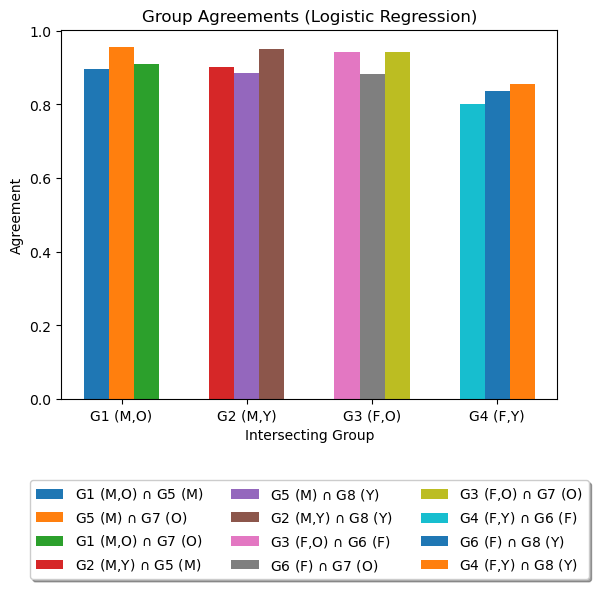

In [24]:
# Get group-conditional agreements
lr_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    lr_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_german_agreements(ax, lr_group_pairs_agreements, group_pairs, group_names, model_class="Logistic Regression")

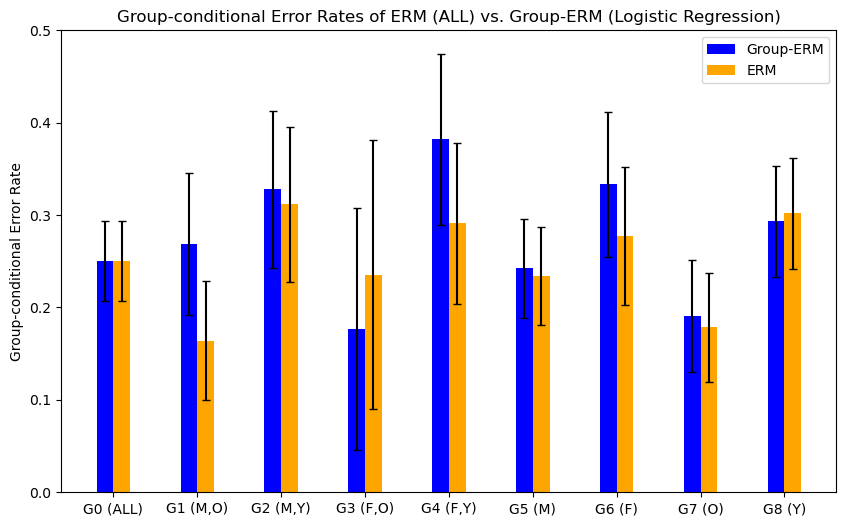

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_german_errors(ax, lr_test_err, lr_std_err, lr_erm_test_err, lr_erm_std_err, model_class="Logistic Regression")

# Decision Trees

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'dectree_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'dectree_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    dectree_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        dectree_models[g] = DecisionTreeClassifier(**best_params[g])
        dectree_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = dectree_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(dectree_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Get test errors for each group
dt_test_err, dt_std_err, dt_erm_test_err, dt_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.31 (+/-0.04624932431938871; n=200)
group 1 (M,O): 0.26865671641791045 (+/-0.0765838307905197; n=67)
group 2 (M,Y): 0.32786885245901637 (+/-0.08500161387980397; n=61)
group 3 (F,O): 0.29411764705882354 (+/-0.1562849798011933; n=17)
group 4 (F,Y): 0.36363636363636365 (+/-0.09173181438354783; n=55)
group 5 (M): 0.34375 (+/-0.059369859974885406; n=128)
group 6 (F): 0.3333333333333333 (+/-0.07856742013183862; n=72)
group 7 (O): 0.25 (+/-0.0668153104781061; n=84)
group 8 (Y): 0.35344827586206895 (+/-0.06276977530849785; n=116)
Group-conditional ERM Test Errors
group 0 (ALL): 0.31 (+/-0.04624932431938871; n=200)
group 1 (M,O): 0.26865671641791045 (+/-0.0765838307905197; n=67)
group 2 (M,Y): 0.32786885245901637 (+/-0.08500161387980397; n=61)
group 3 (F,O): 0.29411764705882354 (+/-0.1562849798011933; n=17)
group 4 (F,Y): 0.36363636363636365 (+/-0.09173181438354783; n=55)
group 5 (M): 0.34375 (+/-0.059369859974885406; n=128)
group 6 (F): 0.3333333333333333 (+/-0.0785674201318386

(M,O, M) agreement on G1 (M,O):	0.7611940298507462
(M, O) agreement on G1 (M,O):	0.8955223880597015
(M,O, O) agreement on G1 (M,O):	0.8059701492537313
(M,Y, M) agreement on G2 (M,Y):	0.7049180327868853
(M, Y) agreement on G2 (M,Y):	0.639344262295082
(M,Y, Y) agreement on G2 (M,Y):	0.7049180327868853
(F,O, F) agreement on G3 (F,O):	0.6470588235294118
(F, O) agreement on G3 (F,O):	0.8235294117647058
(F,O, O) agreement on G3 (F,O):	0.7058823529411765
(F,Y, F) agreement on G4 (F,Y):	0.8
(F, Y) agreement on G4 (F,Y):	0.7818181818181819
(F,Y, Y) agreement on G4 (F,Y):	0.7272727272727273


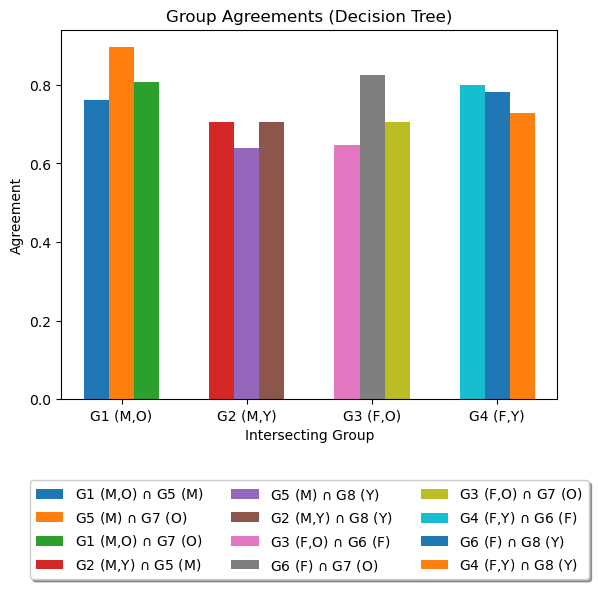

In [29]:
# Get group-conditional agreements
dt_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    dt_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_german_agreements(ax, dt_group_pairs_agreements, group_pairs, group_names, model_class="Decision Tree")

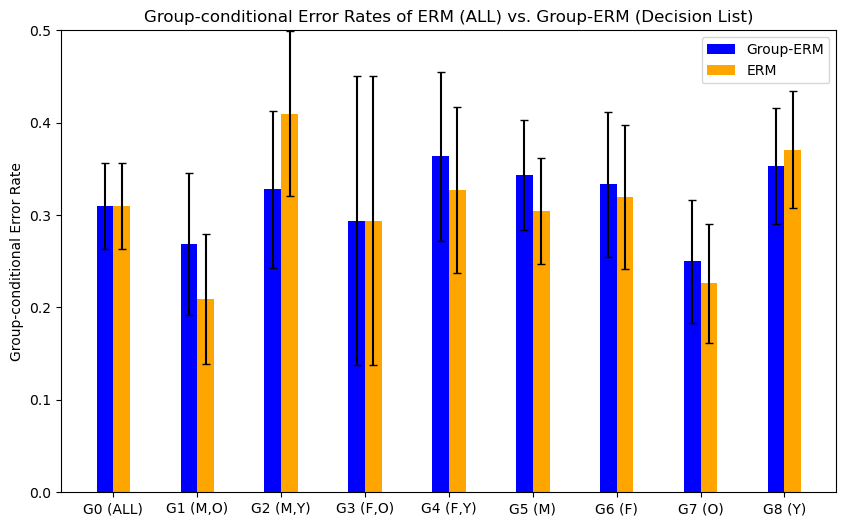

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_german_errors(ax, dt_test_err, dt_std_err, dt_erm_test_err, dt_erm_std_err, model_class="Decision List")

# Random Forests

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'rf_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'rf_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'rf_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    rf_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        rf_models[g] = RandomForestClassifier(**best_params[g])
        rf_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = rf_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(rf_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

rf_test_err, rf_std_err, rf_erm_test_err, rf_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.245 (+/-0.04300872004605578; n=200)
group 1 (M,O): 0.208955223880597 (+/-0.07024327413356514; n=67)
group 2 (M,Y): 0.19672131147540983 (+/-0.0719795137263977; n=61)
group 3 (F,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.36363636363636365 (+/-0.09173181438354783; n=55)
group 5 (M): 0.2578125 (+/-0.05467877999675554; n=128)
group 6 (F): 0.2916666666666667 (+/-0.0757549452405258; n=72)
group 7 (O): 0.20238095238095238 (+/-0.0619951807831965; n=84)
group 8 (Y): 0.28448275862068967 (+/-0.0592412249675808; n=116)
Group-conditional ERM Test Errors
group 0 (ALL): 0.245 (+/-0.04300872004605578; n=200)
group 1 (M,O): 0.208955223880597 (+/-0.07024327413356514; n=67)
group 2 (M,Y): 0.19672131147540983 (+/-0.0719795137263977; n=61)
group 3 (F,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.36363636363636365 (+/-0.09173181438354783; n=55)
group 5 (M): 0.2578125 (+/-0.05467877999675554; n=128)
group 6 (F): 0.2916666666666667 (+/-0.0

(M,O, M) agreement on G1 (M,O):	0.8805970149253731
(M, O) agreement on G1 (M,O):	0.9402985074626866
(M,O, O) agreement on G1 (M,O):	0.9104477611940298
(M,Y, M) agreement on G2 (M,Y):	0.8524590163934426
(M, Y) agreement on G2 (M,Y):	0.819672131147541
(M,Y, Y) agreement on G2 (M,Y):	0.9016393442622951
(F,O, F) agreement on G3 (F,O):	1.0
(F, O) agreement on G3 (F,O):	1.0
(F,O, O) agreement on G3 (F,O):	1.0
(F,Y, F) agreement on G4 (F,Y):	0.9272727272727272
(F, Y) agreement on G4 (F,Y):	0.8727272727272727
(F,Y, Y) agreement on G4 (F,Y):	0.8727272727272727


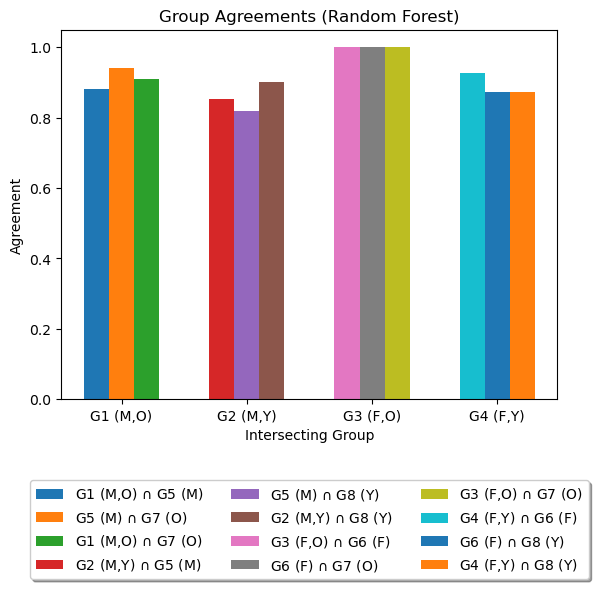

In [34]:
# Get group-conditional agreements
rf_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    rf_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_german_agreements(ax, rf_group_pairs_agreements, group_pairs, group_names, model_class="Random Forest")

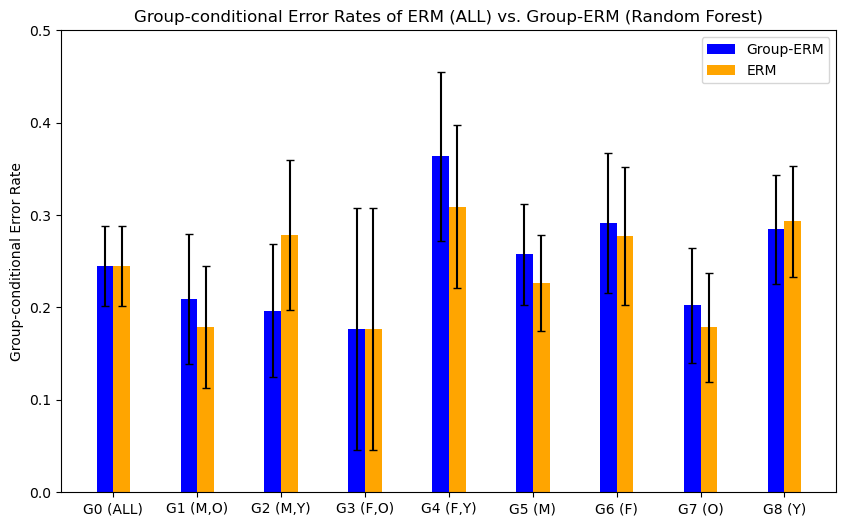

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_german_errors(ax, rf_test_err, rf_std_err, rf_erm_test_err, rf_erm_std_err, model_class="Random Forest")

# Gradient-Boosted Trees

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'gbm_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'gbm_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        gbm_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    gbm_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        gbm_models[g] = GradientBoostingClassifier(**best_params[g])
        gbm_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = gbm_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(gbm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

gb_test_err, gb_std_err, gb_erm_test_err, gb_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.27 (+/-0.044395945760846225; n=200)
group 1 (M,O): 0.2835820895522388 (+/-0.07787538611340035; n=67)
group 2 (M,Y): 0.3114754098360656 (+/-0.08385359585503979; n=61)
group 3 (F,O): 0.35294117647058826 (+/-0.16391306965158492; n=17)
group 4 (F,Y): 0.3090909090909091 (+/-0.08812258383705454; n=55)
group 5 (M): 0.21875 (+/-0.051674830294230284; n=128)
group 6 (F): 0.2777777777777778 (+/-0.07465053470646806; n=72)
group 7 (O): 0.20238095238095238 (+/-0.0619951807831965; n=84)
group 8 (Y): 0.3017241379310345 (+/-0.06027046547837056; n=116)
Group-conditional ERM Test Errors
group 0 (ALL): 0.27 (+/-0.044395945760846225; n=200)
group 1 (M,O): 0.2835820895522388 (+/-0.07787538611340035; n=67)
group 2 (M,Y): 0.3114754098360656 (+/-0.08385359585503979; n=61)
group 3 (F,O): 0.35294117647058826 (+/-0.16391306965158492; n=17)
group 4 (F,Y): 0.3090909090909091 (+/-0.08812258383705454; n=55)
group 5 (M): 0.21875 (+/-0.051674830294230284; n=128)
group 6 (F): 0.2777777777777778 (+/-0.07

(M,O, M) agreement on G1 (M,O):	0.835820895522388
(M, O) agreement on G1 (M,O):	0.9104477611940298
(M,O, O) agreement on G1 (M,O):	0.8059701492537313
(M,Y, M) agreement on G2 (M,Y):	0.8524590163934426
(M, Y) agreement on G2 (M,Y):	0.7868852459016393
(M,Y, Y) agreement on G2 (M,Y):	0.7377049180327869
(F,O, F) agreement on G3 (F,O):	0.8235294117647058
(F, O) agreement on G3 (F,O):	0.8823529411764706
(F,O, O) agreement on G3 (F,O):	0.7058823529411765
(F,Y, F) agreement on G4 (F,Y):	0.7818181818181819
(F, Y) agreement on G4 (F,Y):	0.7272727272727273
(F,Y, Y) agreement on G4 (F,Y):	0.7636363636363637


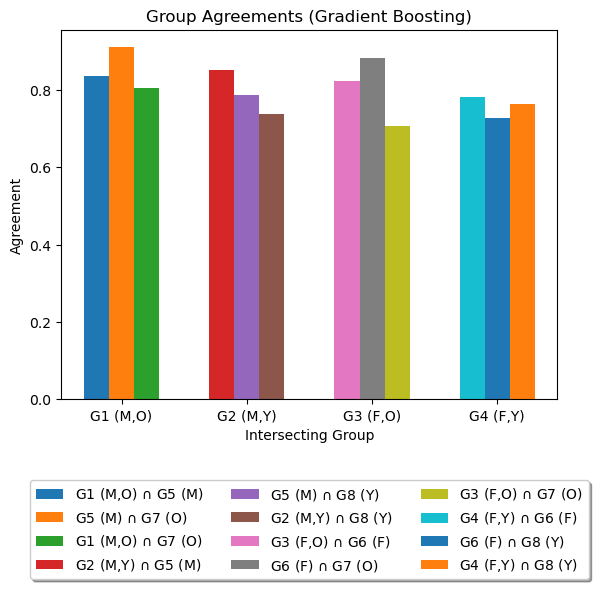

In [39]:
# Get group-conditional agreements
gb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    gb_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_german_agreements(ax, gb_group_pairs_agreements, group_pairs, group_names, model_class="Gradient Boosting")

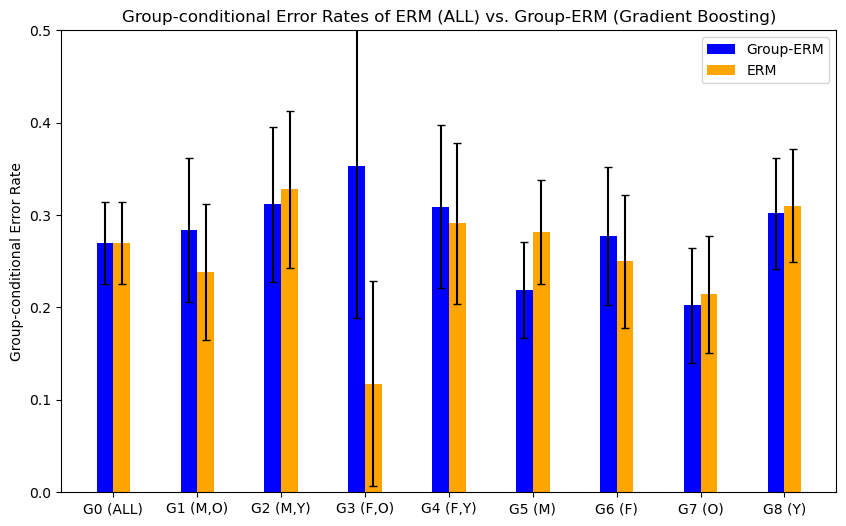

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_german_errors(ax, gb_test_err, gb_std_err, gb_erm_test_err, gb_erm_std_err, model_class="Gradient Boosting")

# XGBoost

In [42]:
from xgboost import XGBClassifier

In [43]:
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'xgb_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'xgb_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        xgb_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    xgb_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        xgb_models[g] = XGBClassifier(**best_params[g])
        xgb_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = xgb_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(xgb_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

xgb_test_err, xgb_std_err, xgb_erm_test_err, xgb_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.24 (+/-0.04270831300812525; n=200)
group 1 (M,O): 0.208955223880597 (+/-0.07024327413356514; n=67)
group 2 (M,Y): 0.29508196721311475 (+/-0.0825830133445969; n=61)
group 3 (F,O): 0.29411764705882354 (+/-0.1562849798011933; n=17)
group 4 (F,Y): 0.32727272727272727 (+/-0.0894763126106972; n=55)
group 5 (M): 0.234375 (+/-0.052950944186429524; n=128)
group 6 (F): 0.3055555555555556 (+/-0.07677372199896759; n=72)
group 7 (O): 0.19047619047619047 (+/-0.06059133431241445; n=84)
group 8 (Y): 0.3103448275862069 (+/-0.06074691926014174; n=116)
Group-conditional ERM Test Errors
group 0 (ALL): 0.24 (+/-0.04270831300812525; n=200)
group 1 (M,O): 0.208955223880597 (+/-0.07024327413356514; n=67)
group 2 (M,Y): 0.29508196721311475 (+/-0.0825830133445969; n=61)
group 3 (F,O): 0.29411764705882354 (+/-0.1562849798011933; n=17)
group 4 (F,Y): 0.32727272727272727 (+/-0.0894763126106972; n=55)
group 5 (M): 0.234375 (+/-0.052950944186429524; n=128)
group 6 (F): 0.3055555555555556 (+/-0.07677

(M,O, M) agreement on G1 (M,O):	0.8208955223880597
(M, O) agreement on G1 (M,O):	0.8955223880597015
(M,O, O) agreement on G1 (M,O):	0.9253731343283582
(M,Y, M) agreement on G2 (M,Y):	0.8032786885245902
(M, Y) agreement on G2 (M,Y):	0.7540983606557377
(M,Y, Y) agreement on G2 (M,Y):	0.7540983606557377
(F,O, F) agreement on G3 (F,O):	0.7647058823529411
(F, O) agreement on G3 (F,O):	0.7647058823529411
(F,O, O) agreement on G3 (F,O):	0.7647058823529411
(F,Y, F) agreement on G4 (F,Y):	0.8727272727272727
(F, Y) agreement on G4 (F,Y):	0.8545454545454545
(F,Y, Y) agreement on G4 (F,Y):	0.8727272727272727


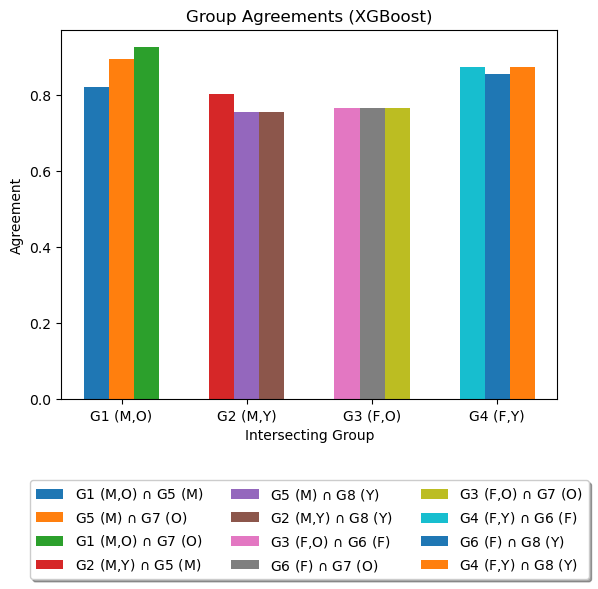

In [44]:
# Get group-conditional agreements
xgb_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    xgb_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_german_agreements(ax, xgb_group_pairs_agreements, group_pairs, group_names, model_class="XGBoost")

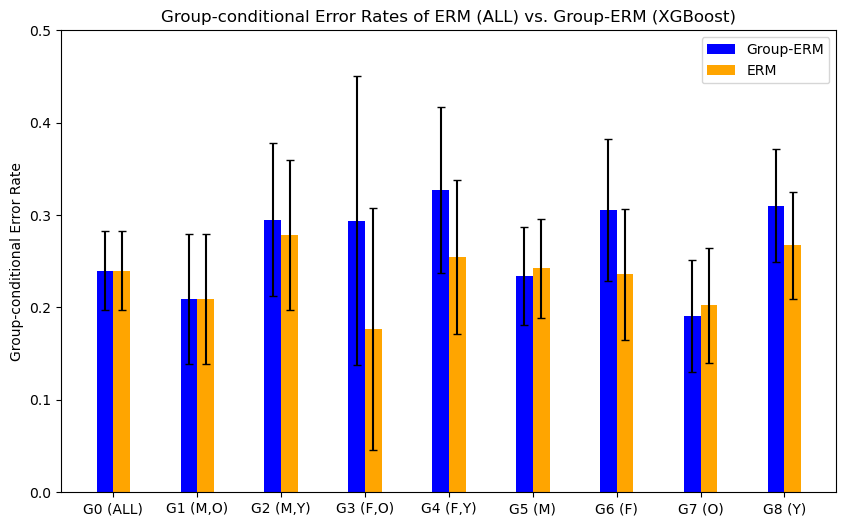

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_german_errors(ax, xgb_test_err, xgb_std_err, xgb_erm_test_err, xgb_erm_std_err, model_class="XGBoost")

# AdaBoost

In [47]:
from sklearn.ensemble import AdaBoostClassifier

In [48]:
LOAD_DATA = False
SAVE_DATA_PATH = 'german_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'ada_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'ada_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'ada_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        ada_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    ada_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        ada_models[g] = AdaBoostClassifier(**best_params[g])
        ada_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = ada_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(ada_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

ada_test_err, ada_std_err, ada_erm_test_err, ada_erm_std_err = group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names)

group 0 (ALL): 0.235 (+/-0.04239988207530771; n=200)
group 1 (M,O): 0.23880597014925373 (+/-0.07366274069214661; n=67)
group 2 (M,Y): 0.29508196721311475 (+/-0.0825830133445969; n=61)
group 3 (F,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.2909090909090909 (+/-0.08660904671107604; n=55)
group 5 (M): 0.25 (+/-0.05412658773652741; n=128)
group 6 (F): 0.25 (+/-0.07216878364870322; n=72)
group 7 (O): 0.2261904761904762 (+/-0.06455494976987063; n=84)
group 8 (Y): 0.29310344827586204 (+/-0.05976878104551381; n=116)
Group-conditional ERM Test Errors
group 0 (ALL): 0.235 (+/-0.04239988207530771; n=200)
group 1 (M,O): 0.23880597014925373 (+/-0.07366274069214661; n=67)
group 2 (M,Y): 0.29508196721311475 (+/-0.0825830133445969; n=61)
group 3 (F,O): 0.17647058823529413 (+/-0.13075739534734385; n=17)
group 4 (F,Y): 0.2909090909090909 (+/-0.08660904671107604; n=55)
group 5 (M): 0.25 (+/-0.05412658773652741; n=128)
group 6 (F): 0.25 (+/-0.07216878364870322; n=72)
group 7 (O

(M,O, M) agreement on G1 (M,O):	0.9253731343283582
(M, O) agreement on G1 (M,O):	0.9253731343283582
(M,O, O) agreement on G1 (M,O):	0.9701492537313433
(M,Y, M) agreement on G2 (M,Y):	0.7540983606557377
(M, Y) agreement on G2 (M,Y):	0.8032786885245902
(M,Y, Y) agreement on G2 (M,Y):	0.8852459016393442
(F,O, F) agreement on G3 (F,O):	1.0
(F, O) agreement on G3 (F,O):	1.0
(F,O, O) agreement on G3 (F,O):	1.0
(F,Y, F) agreement on G4 (F,Y):	0.8727272727272727
(F, Y) agreement on G4 (F,Y):	0.7818181818181819
(F,Y, Y) agreement on G4 (F,Y):	0.7636363636363637


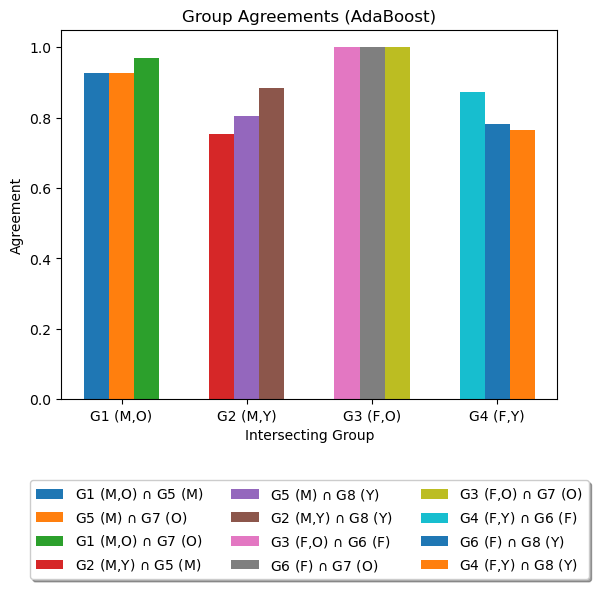

In [49]:
# Get group-conditional agreements
ada_group_pairs_agreements = []
for i, (g1, g2) in enumerate(group_pairs):
    intersection = group_pairs_cond[i]
    agreement = np.sum(yhats[g1][group_test[intersection]] == yhats[g2][group_test[intersection]])/len(y_test[group_test[intersection]])
    print("({}, {}) agreement on G{} ({}):\t{}".format(group_names[g1], group_names[g2], intersection, group_names[intersection], agreement))
    ada_group_pairs_agreements.append(agreement)

fig, ax = plt.subplots()
plot_german_agreements(ax, ada_group_pairs_agreements, group_pairs, group_names, model_class="AdaBoost")

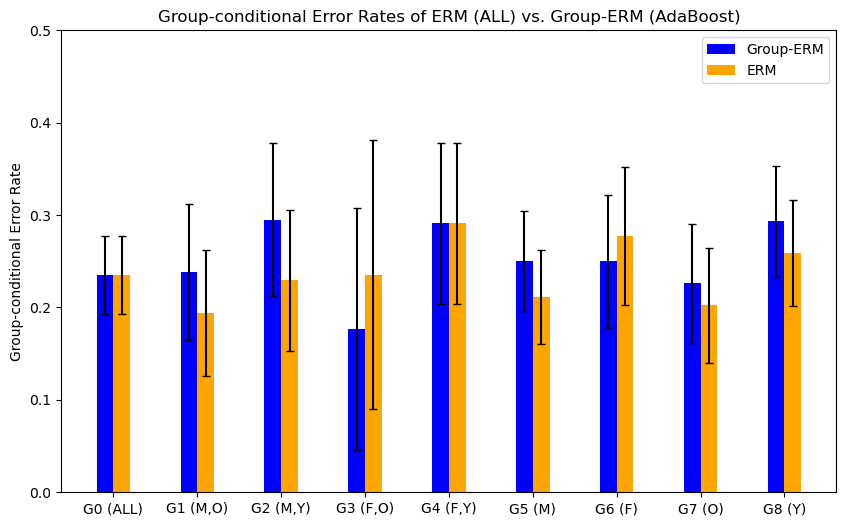

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
plot_german_errors(ax, ada_test_err, ada_std_err, ada_erm_test_err, ada_erm_std_err, model_class="AdaBoost")

# All Together

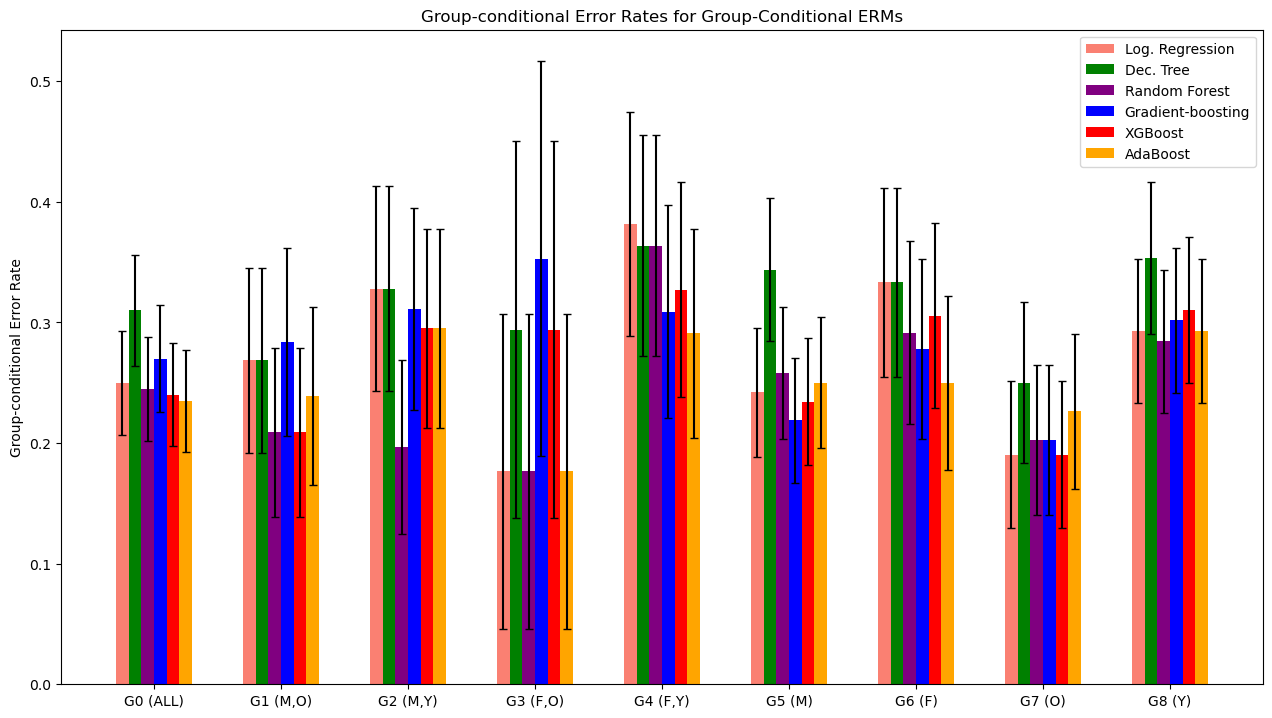

In [51]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 2.5 * bar_width, lr_test_err[g], bar_width, yerr=lr_std_err[g], capsize=3, label="Log. Regression", color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_test_err[g], bar_width, yerr=dt_std_err[g], capsize=3, label="Dec. Tree", color="green")
        ax.bar(g - 0.5 * bar_width, rf_test_err[g], bar_width, yerr=rf_std_err[g], capsize=3, label="Random Forest", color="purple")
        ax.bar(g + 0.5 * bar_width, gb_test_err[g], bar_width, yerr=gb_std_err[g], capsize=3, label="Gradient-boosting", color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_test_err[g], bar_width, yerr=xgb_std_err[g], capsize=3, label="XGBoost", color="red")
        ax.bar(g + 2.5 * bar_width, ada_test_err[g], bar_width, yerr=ada_std_err[g], capsize=3, label="AdaBoost", color="orange")
    else:
        ax.bar(g - 2.5 * bar_width, lr_test_err[g], bar_width, yerr=lr_std_err[g], capsize=3, color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_test_err[g], bar_width, yerr=dt_std_err[g], capsize=3, color="green")
        ax.bar(g - 0.5 * bar_width, rf_test_err[g], bar_width, yerr=rf_std_err[g], capsize=3, color="purple")
        ax.bar(g + 0.5 * bar_width, gb_test_err[g], bar_width, yerr=gb_std_err[g], capsize=3, color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_test_err[g], bar_width, yerr=xgb_std_err[g], capsize=3, color="red")
        ax.bar(g + 2.5 * bar_width, ada_test_err[g], bar_width, yerr=ada_std_err[g], capsize=3, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates for Group-Conditional ERMs')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

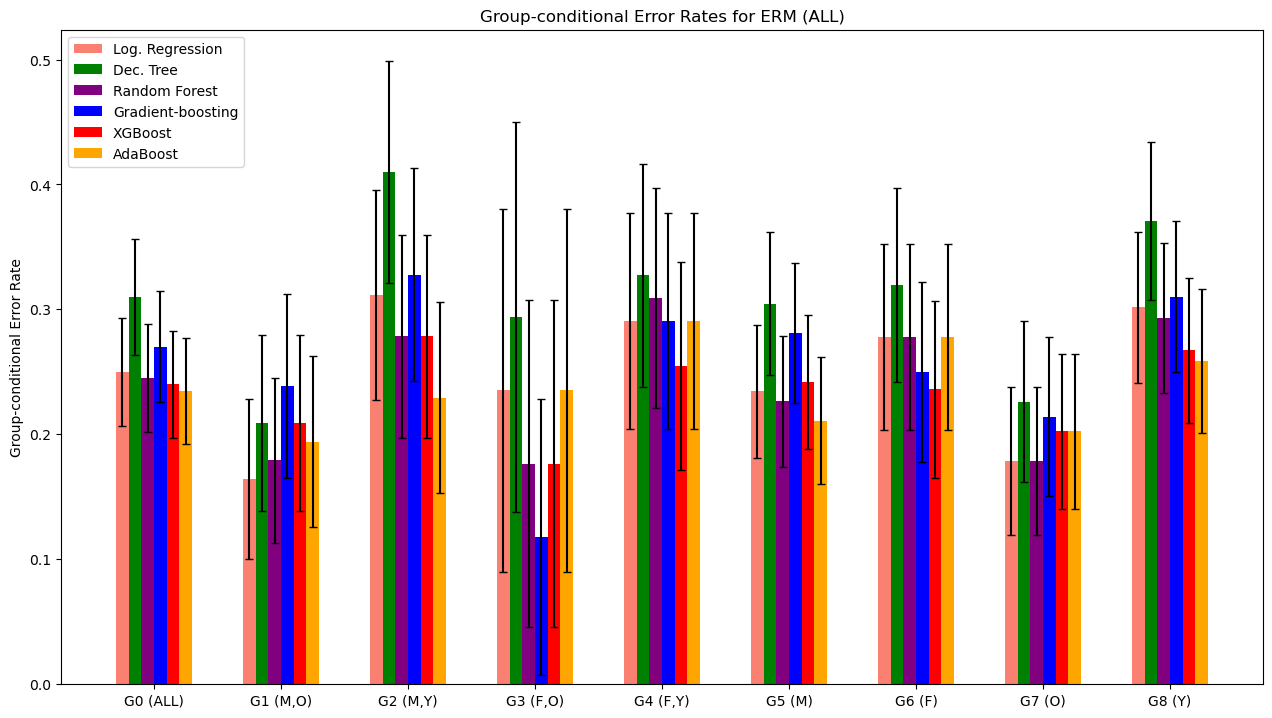

In [52]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 2.5 * bar_width, lr_erm_test_err[g], bar_width, yerr=lr_erm_std_err[g], capsize=3, label="Log. Regression", color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_erm_test_err[g], bar_width, yerr=dt_erm_std_err[g], capsize=3, label="Dec. Tree", color="green")
        ax.bar(g - 0.5 * bar_width, rf_erm_test_err[g], bar_width, yerr=rf_erm_std_err[g], capsize=3, label="Random Forest", color="purple")
        ax.bar(g + 0.5 * bar_width, gb_erm_test_err[g], bar_width, yerr=gb_erm_std_err[g], capsize=3, label="Gradient-boosting", color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_erm_test_err[g], bar_width, yerr=xgb_erm_std_err[g], capsize=3, label="XGBoost", color="red")
        ax.bar(g + 2.5 * bar_width, ada_erm_test_err[g], bar_width, yerr=ada_erm_std_err[g], capsize=3, label="AdaBoost", color="orange")
    else:
        ax.bar(g - 2.5 * bar_width, lr_erm_test_err[g], bar_width, yerr=lr_erm_std_err[g], capsize=3, color="salmon")
        ax.bar(g - 1.5 * bar_width, dt_erm_test_err[g], bar_width, yerr=dt_erm_std_err[g], capsize=3, color="green")
        ax.bar(g - 0.5 * bar_width, rf_erm_test_err[g], bar_width, yerr=rf_erm_std_err[g], capsize=3, color="purple")
        ax.bar(g + 0.5 * bar_width, gb_erm_test_err[g], bar_width, yerr=gb_erm_std_err[g], capsize=3, color="blue")
        ax.bar(g + 1.5 * bar_width, xgb_erm_test_err[g], bar_width, yerr=xgb_erm_std_err[g], capsize=3, color="red")
        ax.bar(g + 2.5 * bar_width, ada_erm_test_err[g], bar_width, yerr=ada_erm_std_err[g], capsize=3, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates for ERM (ALL)')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

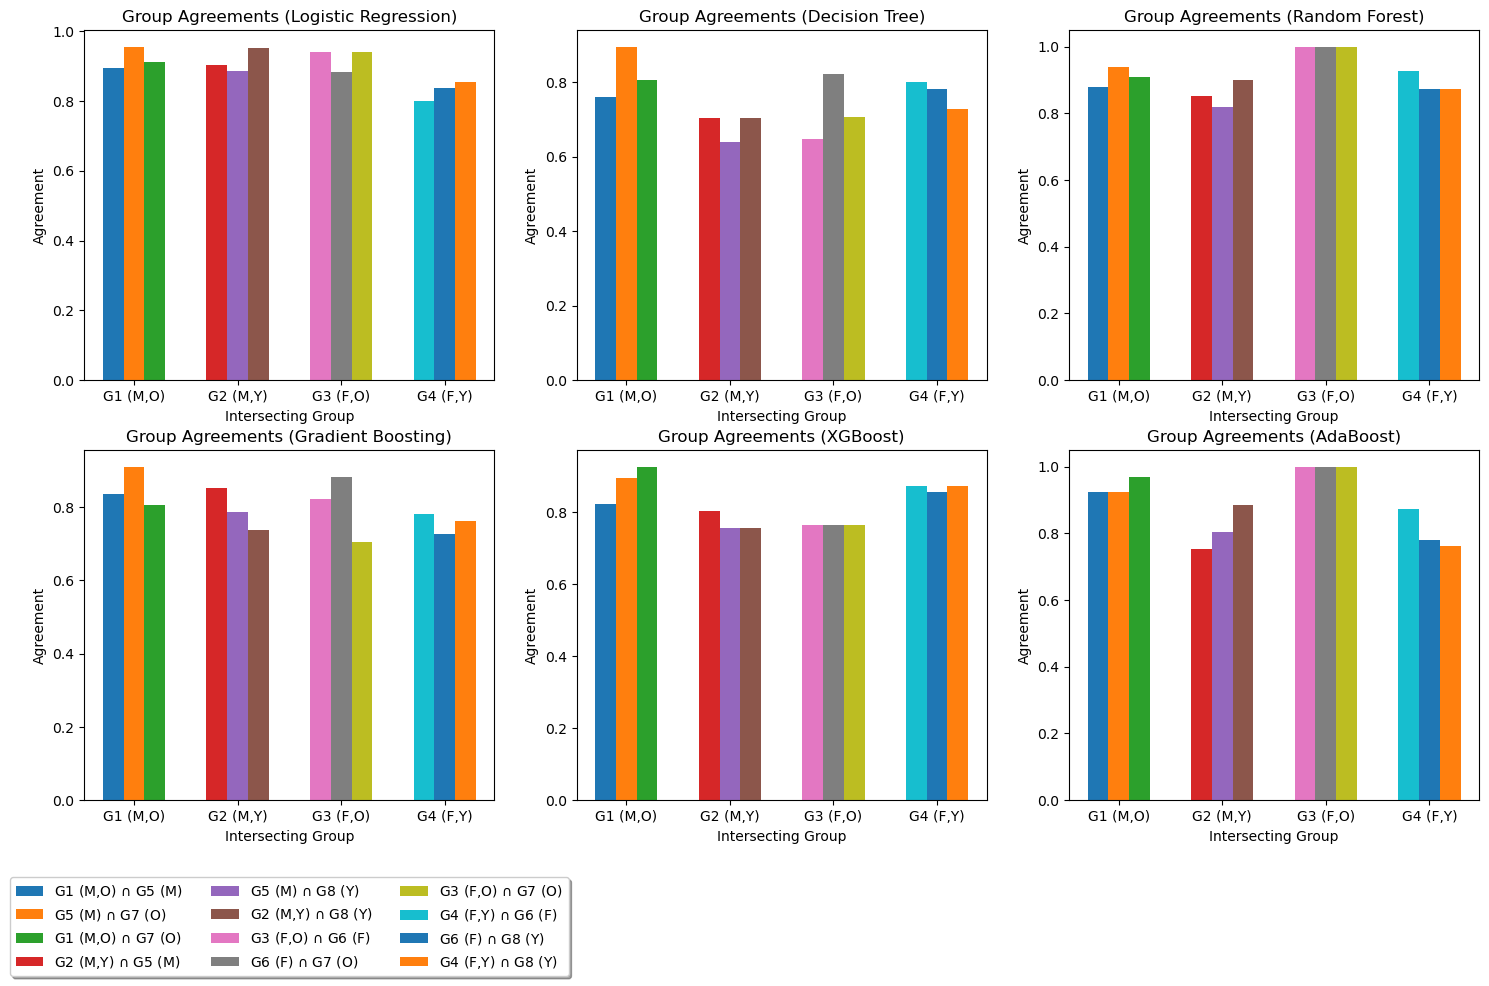

In [54]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(18, 10)
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

plot_german_agreements(ax[0][0], lr_group_pairs_agreements, group_pairs, group_names, model_class="Logistic Regression", legend=False)
plot_german_agreements(ax[0][1], dt_group_pairs_agreements, group_pairs, group_names, model_class="Decision Tree", legend=False)
plot_german_agreements(ax[0][2], rf_group_pairs_agreements, group_pairs, group_names, model_class="Random Forest", legend=False)
plot_german_agreements(ax[1][0], gb_group_pairs_agreements, group_pairs, group_names, model_class="Gradient Boosting", legend=False)
plot_german_agreements(ax[1][1], xgb_group_pairs_agreements, group_pairs, group_names, model_class="XGBoost", legend=False)
plot_german_agreements(ax[1][2], ada_group_pairs_agreements, group_pairs, group_names, model_class="AdaBoost", legend=False)

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

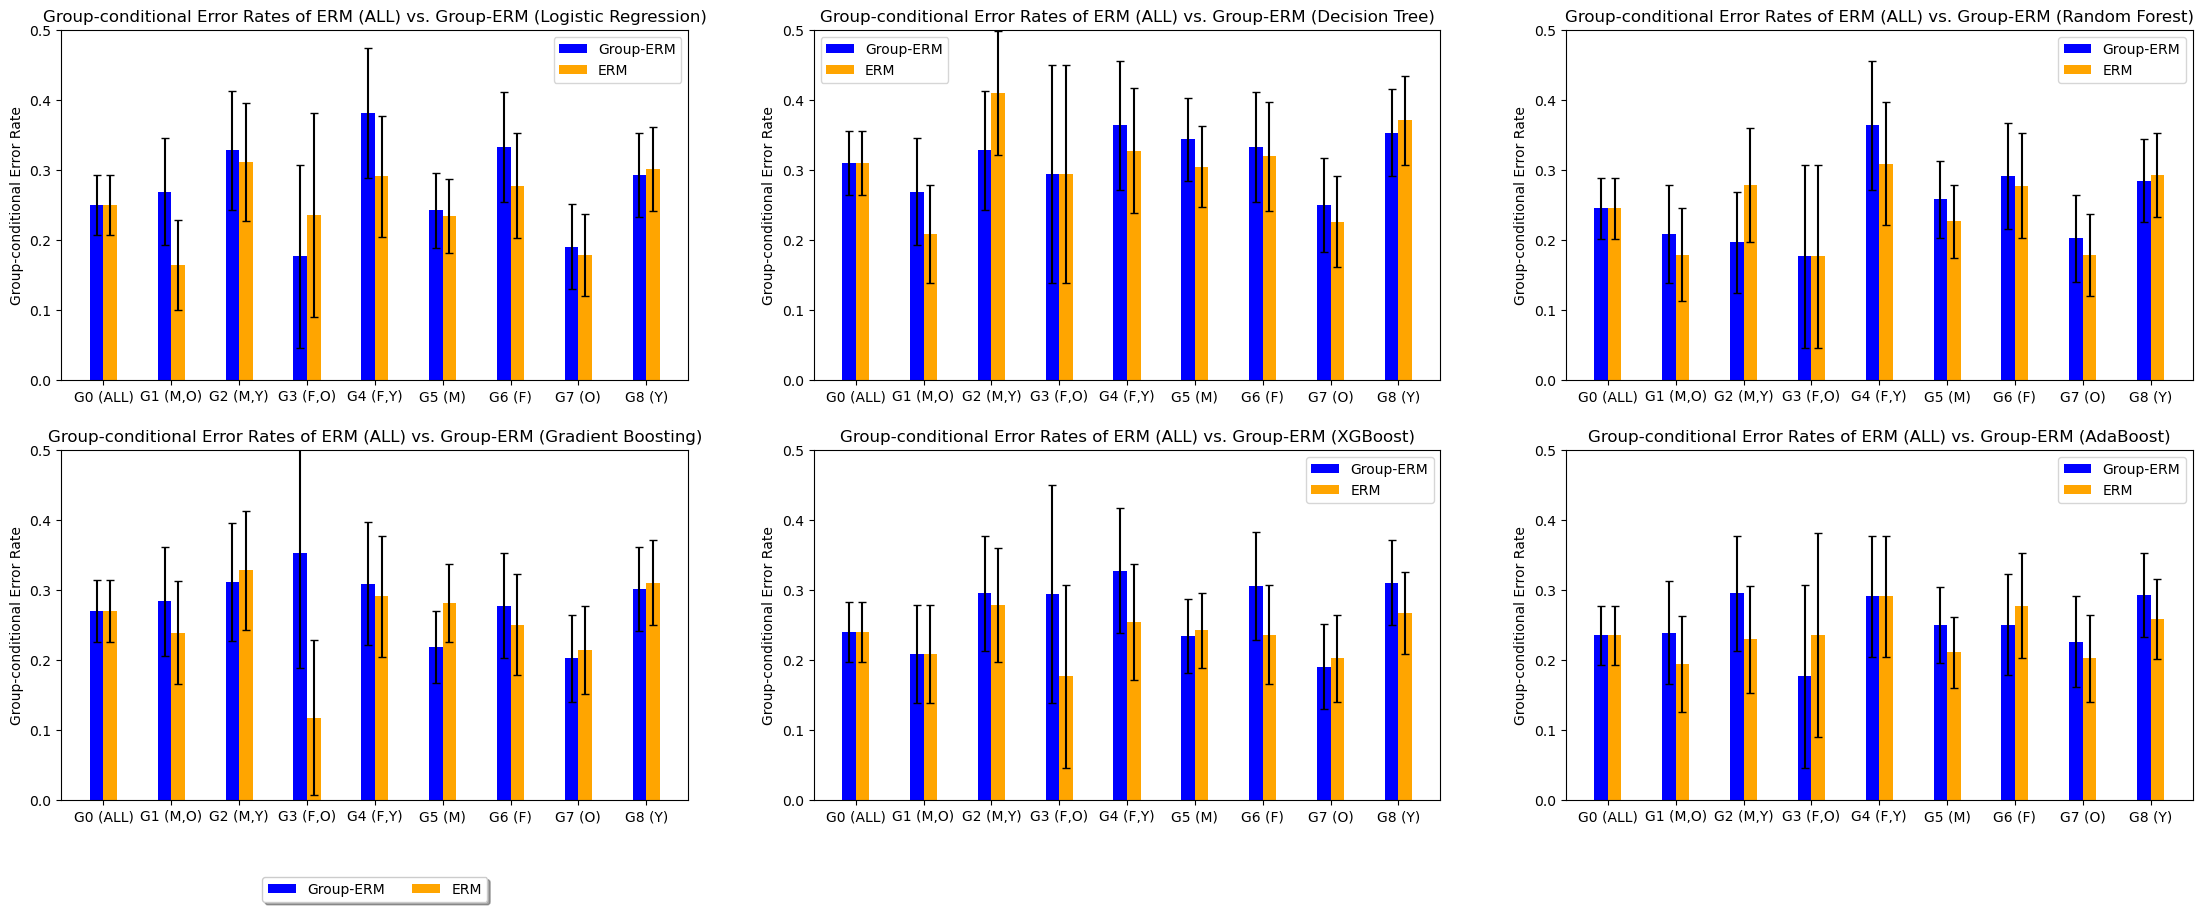

In [55]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(27.5, 10)
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.2

plot_german_errors(ax[0][0], lr_test_err, lr_std_err, lr_erm_test_err, lr_erm_std_err, model_class="Logistic Regression")
plot_german_errors(ax[0][1], dt_test_err, dt_std_err, dt_erm_test_err, dt_erm_std_err, model_class="Decision Tree")
plot_german_errors(ax[0][2], rf_test_err, rf_std_err, rf_erm_test_err, rf_erm_std_err, model_class="Random Forest")
plot_german_errors(ax[1][0], gb_test_err, gb_std_err, gb_erm_test_err, gb_erm_std_err, model_class="Gradient Boosting")
plot_german_errors(ax[1][1], xgb_test_err, xgb_std_err, xgb_erm_test_err, xgb_erm_std_err, model_class="XGBoost")
plot_german_errors(ax[1][2], ada_test_err, ada_std_err, ada_erm_test_err, ada_erm_std_err, model_class="AdaBoost")

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()